In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import numpy as np
from pybedtools import BedTool

def conversion_table():
    return pd.read_table('/stor/work/Lambowitz/ref/benchmarking/human_transcriptome/transcripts.tsv')

def read_db():
    gene_expr = '/stor/work/Lambowitz/cdw2854/EV_polyA/published_expr/rna_tissue.tsv'
    expr_df = pd.read_table(gene_expr) \
        .pivot_table(index='Gene', 
                columns = 'Sample',
                values = 'Value')\
        .reset_index() \
        .rename(columns = {'Gene':'gene_id'})
    return expr_df

In [2]:
salmon_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/salmon_result'
sample_folders = glob.glob(salmon_path + '/Q*')

read_table_func = lambda x: pd.read_table(x + '/quant.genes.sf').assign(samplename = os.path.basename(x))
sf_df = pd.concat(map(read_table_func, sample_folders)) \
    .rename(columns = {'Name':'gene_id'}) \
    .merge(conversion_table(), on = 'gene_id')\
    .groupby(['name','samplename'], as_index=False)\
    .agg({'TPM':'sum'}) \
    .pipe(pd.pivot_table, columns = 'samplename', index='name', values = 'TPM', fill_value = 0) \
    .reset_index()\

sf_df.head()
# .assign(Name = lambda d: d.Name.str.replace('_gene','')) \
#    .assign(Name = lambda d: np.where(d.Name.str.contains('^TR'), 
#                                      d.Name.str.extract('(TR.*-[ACTG]{3})', expand=False),
#                                     d.Name)) \

,name
samplename,


KeyError: 'Qcf_L1'

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


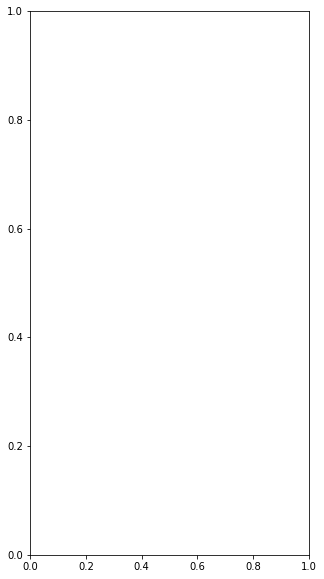

In [3]:
top_n = 100
fig = plt.figure(figsize=(5,10))
ax = fig.add_subplot(111)
plot_df = sf_df\
                .set_index('name')\
                .filter(regex='Qcf')\
                .sort_values('Qcf_L1',ascending=False)\
                .head(top_n)\
                .transform(np.log10)
sns.heatmap(plot_df,
           cmap = 'viridis', ax = ax) 
ax.set_yticks(range(top_n))
xt = ax.set_yticklabels(plot_df.index)

In [43]:
read_table_func = lambda x: pd.read_table(x + '/quant.genes.sf').assign(samplename = os.path.basename(x))
sf_df = pd.concat(map(read_table_func, sample_folders)) \
    .rename(columns = {'Name':'gene_id'})\
    .pipe(pd.pivot_table, columns = 'samplename', index='gene_id', values = 'TPM', fill_value = 0) \
    .merge(read_db(), on ='gene_id') 


,gene_id,Qcf_Frag1,Qcf_Frag2,Qcf_L1,Qcf_L2,adipose tissue,adrenal gland,appendix,bone marrow,breast,...,skeletal muscle,skin,small intestine,smooth muscle,spleen,stomach,testis,thyroid gland,tonsil,urinary bladder
0,ENSG00000000003,0.135932,0.025986,0.698563,0.197603,31.5,26.4,9.2,0.7,53.4,...,1.6,7.8,18.8,18.3,14.3,21.2,84.7,53.2,10.2,55.3
1,ENSG00000000005,0.063325,0.044543,2.855190,0.000000,10.1,0.2,0.7,0.0,4.3,...,0.0,0.3,0.1,0.9,0.2,0.0,0.3,0.1,0.1,0.2
2,ENSG00000000419,0.210476,0.000000,22.591000,8.114730,45.6,69.7,46.0,36.3,52.3,...,19.2,40.5,43.1,54.2,50.3,34.6,73.3,80.5,48.0,48.8
3,ENSG00000000457,0.425690,0.006979,0.801649,1.159500,5.7,7.7,9.9,2.6,13.7,...,2.3,9.2,7.6,9.2,10.4,7.3,12.3,12.8,9.0,9.2
4,ENSG00000000460,0.210476,0.017011,5.702480,1.124630,2.0,1.6,4.5,5.9,3.6,...,0.0,2.9,2.0,4.2,3.9,1.8,18.6,2.9,7.3,3.6


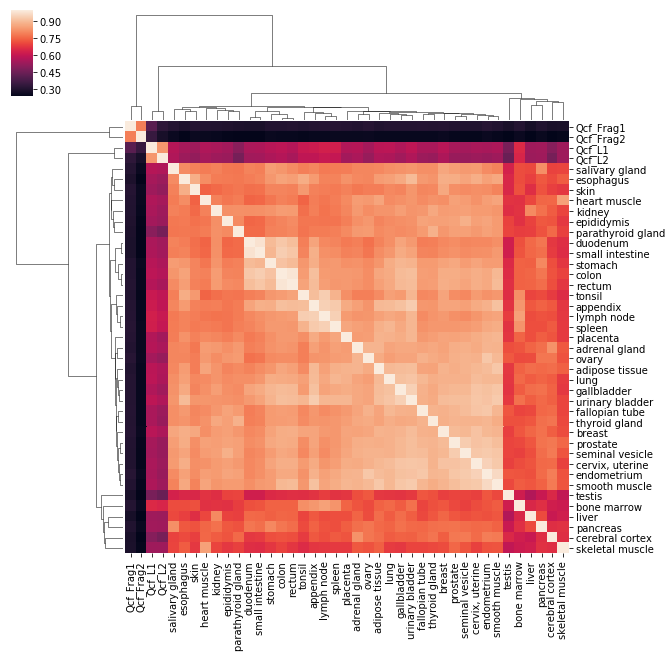

In [44]:
sns.clustermap(sf_df.drop('gene_id', axis=1).transform(lambda x: np.log(x+1)).corr())

# Full length RNA #

In [3]:
bed = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/merged_bed/unfragmented.bed.gz'
protein = '/stor/work/Lambowitz/ref/hg19/new_genes/protein.bed.gz'

coverage = BedTool(protein)\
        .coverage(b = bed,  
                   sorted=True,
                   s=True, hist=True)

In [4]:
cov_df = coverage\
    .to_dataframe()\
    .query('itemRgb > 1') \
    .groupby('chrom|start|end|name|strand|thickStart'.split('|'), 
             as_index=False)\
    .agg({'blockStarts':'sum',
          'blockCount':'sum'})\
    .sort_values('blockStarts', ascending=False)
cov_df.head()

,chrom,start,end,name,strand,thickStart,blockStarts,blockCount
1719,chr11,5246694,5250625,HBB,-,protein_coding,1.0,3931.0
9328,chr6,26027124,26027480,HIST1H4B,-,protein_coding,1.0,356.0
8313,chr4,9217131,9219082,USP17L11,+,protein_coding,1.0,1951.0
9364,chr6,27114197,27114577,HIST1H2BK,-,protein_coding,1.0,380.0
8320,chr4,9331637,9333588,USP17L25,+,protein_coding,1.0,1951.0


In [5]:
cov_df.query('blockStarts > 0.8')

,chrom,start,end,name,strand,thickStart,blockStarts,blockCount
1719,chr11,5246694,5250625,HBB,-,protein_coding,1.000000,3931.0
9328,chr6,26027124,26027480,HIST1H4B,-,protein_coding,1.000000,356.0
8313,chr4,9217131,9219082,USP17L11,+,protein_coding,1.000000,1951.0
9364,chr6,27114197,27114577,HIST1H2BK,-,protein_coding,1.000000,380.0
8320,chr4,9331637,9333588,USP17L25,+,protein_coding,1.000000,1951.0
8315,chr4,9226622,9228573,USP17L13,+,protein_coding,1.000000,1951.0
9340,chr6,26188993,26189304,HIST1H4D,-,protein_coding,1.000000,311.0
8316,chr4,9236111,9238060,USP17L15,+,protein_coding,1.000000,1949.0
5176,chr18,44549424,44550298,ELOA3B,-,protein_coding,1.000000,874.0
9332,chr6,26056015,26056656,HIST1H1C,-,protein_coding,1.000000,641.0
